# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize parameters


In [2]:
def initialize_parameters(layers_dims):
  """
  Initialize parameters using "He initialization"

  Args:
    layers_dims: (list) with the dimensions for each layer in the network

  Returns:
    paramters: (dict)with the network parameters W{layer} and b{layer}
      the shape for each parameter will be:
      W = (neurons in the current layer, neurons in the previous layer)
      b = (neurons in the current layer, 1)
  """

  parameters = {}
  # number of layers
  L = len(layers_dims)

  # initialize parameters using He

  for l in range(1, L):
    # layer 0 is the size of the input layer
    previous = layers_dims[l-1]
    current = layers_dims[l]
    #                                                          He initialization
    parameters[f'W{l}'] = np.random.randn(current, previous) * np.sqrt(2 / previous)
    parameters[f'b{l}'] = np.zeros((current, 1))

  return parameters

# Compute cost function for batch gradient descent


In [12]:
def compute_cost(A_output, y):
  """
  Implements the cost function

  Arguments:
    A_output: output of the forward propagation
    y: true labels, it has the same dimension that A_output

  Returns:
    cost: Value of the cost function
  """
    
  m = y.shape[1]
  cost = (1. / m) * (- np.dot(y, np.log(A_output).T) - np.dot(1 - y, np.log(1 - A_output).T))
  cost = np.squeeze(cost)
    
  return cost

# Compute cost function when using minibatch

In [10]:
def compute_cost_minibatch(A_output, y):
  """
  Implements the cost function

  Args:
    A_output: output of the forward propagation
    y: true labels, it has the same dimension that A_output

  Returns:
    cost: Value of the cost function
  """
  logprobs = np.multiply(- np.log(A_output), y) + np.multiply(- np.log(1 - A_output), 1 - y)
  cost = np.nansum(logprobs)
  cost = np.squeeze(cost)

  return cost

# Compute forward propagation

In [4]:
def forward_propagation(X, parameters):
  """
  Implements the forward propagation. It uses ReLU for hidden layers
  and sigmoid for the output layer. (Only binary classification)

  Args:
    X: dataset of shape(input_size, number of examples)
    parameters: (dict) initialized parameters for W and b

  Returns:
    A_output: output of the forward propagation pass
    cache: (dict) containing Z and A for each layer.
      Z = linear computation for each layer
      A = activations for each layer
    L: (int) number of hidden layers
  """
  
  cache = {}
  A = X
  cache[f'A{0}'] = A
  # number of hidden layers
  L = len(parameters) // 2

  # applied linear -> relu in the hidden layers
  for l in range(1, L):
    W = parameters[f'W{l}']
    b = parameters[f'b{l}']
    Z = W.dot(A) + b
    cache[f'Z{l}'] = Z

    # applied activation function, relu in this case
    A = np.maximum(0, Z)
    cache[f'A{l}'] = A

  # we applie linear -> sigmoid in the output layer
  W = parameters[f'W{L}']
  b = parameters[f'b{L}']
  Z = W.dot(A) + b
  cache[f'Z{l}'] = Z
  A_output = 1 / (1 + np.exp(-Z))
  cache[f'A{L}'] = A_output

  return A_output, cache, L
    



# Compute backpropagation

In [5]:
def backpropagation(X, y, cache, parameters, L):
  """
  Implements backpropagation for binary classification.

  Args:
    X: dataset of shape(input_size, number of examples)
    y: true labels, it has the same dimension that A_output
    cache: (dict) containing Z and A for each layer.
      Z = linear computation for each layer
      A = activations for each layer
    parameters: (dict)with the network parameters W{layer} and b{layer}
      the shape for each parameter will be:
      W = (neurons in the current layer, neurons in the previous layer)
      b = (neurons in the current layer, 1)
    L: (int) number of hidden layers

  Returns:
    grads: (dict) with the gradients with respect to each parameter.
      Activations (dA), Weights (dW), biases (db)
  """

  grads = {}
  m = X.shape[1]

  # calculate the backprop of the output layer
  dZ = cache[f'A{L}'] - y
  grads[f'dW{L}'] = 1. / m * np.dot(dZ, cache[f'A{L - 1}'].T)
  grads[f'db{L}'] = 1. / m * np.sum(dZ, axis= 1, keepdims= True)

  # Calculate the backprop for the hidden layers
  for l in reversed(range(L - 1)):
    grads[f'dA{l + 1}'] = np.dot(parameters[f'W{l + 2}'].T, dZ)
    dZ = np.multiply(grads[f'dA{l + 1}'], np.int64(cache[f'A{l + 1}'] > 0))
    grads[f'dW{l + 1}'] = 1. / m * np.dot(dZ, cache[f'A{l}'].T)
    grads[f'db{l + 1}'] = 1. / m * np.sum(dZ, axis=1, keepdims=True)

  return grads




# Mini batches

In [6]:
def mini_batches(X, y, mini_batch_size=64):
  """
  Creates a list of random minibatches

  Args:
    X: dataset of shape(input_size, number of examples)
    y: true labels, it has the same dimension that A_output
    mini_batch_size: (int) size of the minibatches
  
  Returns:
    mini_batches: (list) with the minibatches
  """
  import math
  m = X.shape[1]
  mini_batches = []

  # Shuffle X and y
  permutation = list(np.random.permutation(m))
  shuffled_X = X[:, permutation]
  shuffled_y = y[:, permutation].reshape((1, m))

  # number of batches with mini_batch_size
  num_complete_minibatches = math.floor(m / mini_batch_size)
  for k in range(0, num_complete_minibatches):
    mini_batch_X = shuffled_X[:, k * mini_batch_size: (k + 1) * mini_batch_size]
    mini_batch_y = shuffled_y[:, k * mini_batch_size: (k + 1) * mini_batch_size]

    mini_batch = (mini_batch_X, mini_batch_y)
    mini_batches.append(mini_batch)

  # Handling the end case (last mini-batch < mini_batch_size)
  if m % mini_batch_size != 0:
    mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size:]
    mini_batch_y = shuffled_y[:, num_complete_minibatches * mini_batch_size:]

    mini_batch = (mini_batch_X, mini_batch_y)
    mini_batches.append(mini_batch)

  return mini_batches


# Adam optimizer

In [8]:
def initialize_adam(parameters):
  """
  Initialize parameters needed for the adam optimizer.

  Args:
    parameters: (dict) with the parameters W and b of each layer
  
  Returns:
    v: (dict) contains the exponentially weighted average of past gradients
    s: (dict) contains the exponentially weighted average of the squares of the past gradients
  """
  # Number of layers
  L = len(parameters) // 2

  # exponentially weighted average of past gradients
  v = {}
  # exponentially weighted average of the squares of the past gradients
  s = {}

  for l in range(L):
    v[f"dW{l + 1}"] = np.zeros_like(parameters[f"W{l + 1}"])
    v[f"db{l + 1}"] = np.zeros_like(parameters[f"b{l + 1}"])
    s[f"dW{l + 1}"] = np.zeros_like(parameters[f"W{l + 1}"])
    s[f"db{l + 1}"] = np.zeros_like(parameters[f"b{l + 1}"])

  return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
  """
  Update parameters using Adam

  Args:
    parameters: (dict) with the parameters W and b of each layer
    grads: (dict) with the gradients with respect to each parameter.
    v: (dict) contains the exponentially weighted average of past gradients
    s: (dict) contains the exponentially weighted average of the squares of the past gradients
    beta1: (float) exponential decay hyperparameter for the first moment estimates 
    beta2: (float) exponential decay hyperparameter for the second moment estimates
    epsilon: hyperparameter preventing division by zero in Adam updates

  Returns:
    parameters: (dict) with the parameters W and b of each layer
    v: (dict) moving average of the first gradient
    s: (dict) moving average of the squared gradient
  """

  # number of layers
  L = len(parameters) // 2
  # Initializing first moment estimate
  v_corrected = {}
  # Initializing second moment estimate
  s_corrected = {}

  # Update all parameters
  for l in range(L):
    # Moving average of the gradients
    v[f"dW{l + 1}"] = beta1 * v[f"dW{l + 1}"] + (1 - beta1) * grads[f"dW{l + 1}"]
    v[f"db{l + 1}"] = beta1 * v[f"db{l + 1}"] + (1 - beta1) * grads[f"db{l + 1}"]

    # Compute bias-corrected first moment estimate
    v_corrected[f"dW{l + 1}"] = v[f"dW{l + 1}"] / (1 - np.power(beta1, t))
    v_corrected[f"db{l + 1}"] = v[f"db{l + 1}"] / (1 - np.power(beta1, t))

    # Moving average of the squared gradients
    s[f"dW{l + 1}"] = beta2 * s[f"dW{l + 1}"] + (1 - beta2) * np.power(grads[f"dW{l + 1}"], 2)
    s[f"db{l + 1}"] = beta2 * s[f"db{l + 1}"] + (1 - beta2) * np.power(grads[f"db{l + 1}"], 2)

    # Compute bias-corrected second raw moment estimate
    s_corrected[f"dW{l + 1}"] = s[f"dW{l + 1}"] / (1 - np.power(beta2, t))
    s_corrected[f"db{l + 1}"] = s[f"db{l + 1}"] / (1 - np.power(beta2, t))

    # Update parameters
    parameters[f"W{l + 1}"] = parameters[f"W{l + 1}"] - learning_rate * v_corrected[f"dW{l + 1}"] / np.sqrt(s_corrected[f"dW{l + 1}"] + epsilon)
    parameters[f"b{l + 1}"] = parameters[f"b{l + 1}"] - learning_rate * v_corrected[f"db{l + 1}"] / np.sqrt(s_corrected[f"db{l + 1}"] + epsilon)

  return parameters, v, s

# Update parameters batch gradient descent

In [9]:
def update_parameters(grads, parameters, learning_rate):
  """
  Updates parameters using gradient descent

  Args:
    grads: (dict) with the gradients with respect to each parameter
    parameters: (dict) with the parameters W and b of each layer
  
  Returns:
    parameters: (dict) with the updated parameters
  """
  # number of layers
  L = len(parameters) //2

  for l in range(L):
    parameters[f'W{l + 1}'] = parameters[f'W{l + 1}'] - learning_rate * grads[f'dW{l + 1}']
    parameters[f'b{l + 1}'] = parameters[f'b{l + 1}'] - learning_rate * grads[f'db{l + 1}']

  return parameters
  

# Prediction

In [13]:
def predict(X, y, parameters):
  """
  Predicts the results

  Args:
    X: dataset of shape(input_size, number of examples)
    y: true labels, it has the same dimension that A_output
    parameters: (dict) with the parameters W and b of each layer

  Returns:
    p: predictions for the given dataset
  """
  m = X.shape[1]
  p = np.zeros((1,m), dtype = np.int)
    
  # Forward propagation
  A_output, cache = forward_propagation(X, parameters)
    
  # convert probas to 0/1 predictions
  for i in range(0, A_output.shape[1]):
      if A_output[0,i] > 0.5:
          p[0,i] = 1
      else:
          p[0,i] = 0

  # print results
  print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
  return p


# Create the model function

Here we will put all the above functions together to create the model.

In [19]:
def model(X, y, layers_dims, optimizer='adam',  learning_rate=0.0007, mini_batch_size=64, beta=0.9,
          beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=False):
  
  L = len(layers_dims)
  t = 0
  m = X.shape[1]
  costs = []

  # Initialize parameters                      
  parameters = initialize_parameters(layers_dims)

  # Initialize the optimizer
  if optimizer == 'adam':
    v, s = initialize_adam(parameters)
  
  for i in range(0, num_epochs):

    # Define the random minibatches

    minibatches = mini_batches(X, y, mini_batch_size)
    cost_total = 0

    for mini_batch in minibatches:

      # Select mini-batch
      (mini_batch_X, mini_batch_y) = mini_batch

      # Forward propagation: linear -> ReLU -> linear -> sigmoid
      A_output, cache, L = forward_propagation(mini_batch_X, parameters)

      # Compute cost and add to the cost total
      cost_total += compute_cost_minibatch(A_output, mini_batch_y)

      # Back propagation
      grads = backpropagation(mini_batch_X, mini_batch_y, cache, parameters, L)

      # Update parameters
      if optimizer == 'adam':
        t = t + 1 # Adam counter
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, 
                                                       learning_rate, beta1, beta2,  epsilon)
        
    cost_avg = cost_total / m

    # Print the cost every 1000 epochs
    if print_cost and i % 1000 == 0:
      print(f"Cost after epoch {i}: {cost_avg}")
    if print_cost and i % 100 == 0:
      costs.append(cost_avg)

  # plot the cost
  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations (per hundreds)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

  return parameters

# Load dataset


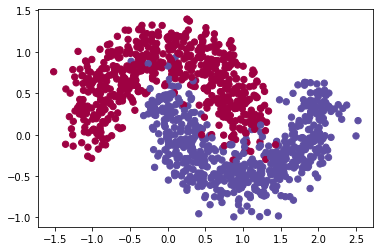

In [23]:
def load_dataset():
    import sklearn
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=1200, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

X, y = load_dataset()


# Model arguments

In [26]:
layers_dims = [X.shape[0], 64, 32, 8, 1]
learning_rate = 0.0007
num_epochs = 10000
mini_batch_size = 64


Cost after epoch 0: 0.5359174287738361
Cost after epoch 1000: 0.05452906195873779


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


Cost after epoch 2000: 0.044254351368750035
Cost after epoch 3000: 0.03242105269536368


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


Cost after epoch 4000: 0.016508712136350554
Cost after epoch 5000: 0.009984582878900538
Cost after epoch 6000: 0.007194887494493673
Cost after epoch 7000: 0.0054860690198592745
Cost after epoch 8000: 0.005010321539553995
Cost after epoch 9000: 0.0034113694598456425


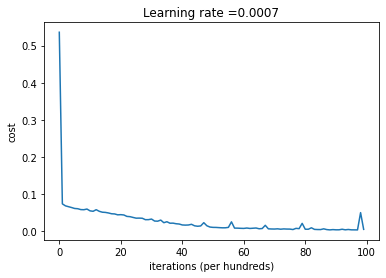

In [27]:
parameters = model(X, y, layers_dims, learning_rate=learning_rate, num_epochs=num_epochs, print_cost=True)